### Notebook to genereate boxplots for ddt(CWV) binned by cloud classification scheme.

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
12/15/23

In [46]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt
import subprocess
import sys
from thermo_functions import theta_virtual, relh, theta_equiv
from cfads_functions import mask_edges
from precip_class import precip_class
import seaborn as sns
import xarray as xr

#### Main settings

In [47]:
# Number of sample time steps
nt=200 # will be chopped down to max available
nt=48

#### Additional settings and directories

In [48]:
storm = 'haiyan'
# storm = 'maria'

# main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'
datdir2 = 'post/d02/'

# Tests to read and compare
# tests = ['crfon','ncrf']
# if storm == 'haiyan':
#     tests = ['ctl','ncrf36h']
# elif storm == 'maria':
#     # tests = ['ctl','ncrf36h']
#     tests = ['ctl','ncrf48h']
tests = ['ctl']

time_neglect=12 # time steps from start to neglect

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
# nmem = 5
nmem = 2
enstag = str(nmem)

In [49]:
# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

##### Get dimensions

datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'+datdir2
datdir3d = datdir #+'v2/'
varfil_main = Dataset(datdir3d+'T.nc')
nz = varfil_main.dimensions['level'].size
nx1 = varfil_main.dimensions['lat'].size
nx2 = varfil_main.dimensions['lon'].size
nt_data = varfil_main.dimensions['time'].size
nt=np.min([nt,nt_data-time_neglect])
pres = varfil_main.variables['pres'][:] # hPa
dp = (pres[1]-pres[0])*1e2 # Pa
varfil_main.close()

# process = subprocess.Popen(['ls '+main+storm+'/'+memb_all[0]+'/'+tests[0]+'/wrfout_d02_*'],shell=True,
#     stdout=subprocess.PIPE,universal_newlines=True)
# output = process.stdout.readline()
# wrffil = output.strip() #[3]
# varfil_main = Dataset(wrffil)
# lat = varfil_main.variables['XLAT'][:][0] # deg
# lon = varfil_main.variables['XLONG'][:][0] # deg
# varfil_main.close()

#### NetCDF variable read functions

In [50]:
def var_read_3d(datdir,varname,t0,t1):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][t0:t1,:,:,:]
    varfil_main.close()
    mask_edges(var)
    return var
def var_read_2d(datdir,varname,t0,t1):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][t0:t1,:,:,:]
    varfil_main.close()
    mask_edges(var)
    return var

#### Main loops and compositing

In [51]:
# Main read loops for 3D (dependent) variables

# Arrays to save variables
ntest=len(tests)
dims = (ntest, nmem, nt, nx1, nx2)
strat_all  = np.ma.zeros(dims)
cwv_all    = np.ma.zeros(dims)

for ktest in range(ntest):

    test_str=tests[ktest]

    # This has been tested for corresponding time steps:
    #   t0=37,1 are the first divergent time steps in CTL,NCRF
    #   t0=25,1 are the first divergent time steps in NCRF,CRFON
    # if test_str == 'ctl':
    #     if tests[1] == 'ncrf36h':
    #         t0=36
    #     elif tests[1] == 'ncrf48h':
    #         t0=48
    # elif test_str == 'ncrf36h':
    #     t0=t0_test
    # elif test_str == 'ncrf48h':
    #     t0=t0_test
    # elif test_str == 'crfon':
    #     t0=0
    t0=time_neglect # neglect the first 12 time steps
    t1=t0+nt

    # t0+=1 # add one time step since NCRF(t=0) = CTL
    # t1 = t0+nt

    print('Running test: ',test_str)

    # Loop over ensemble members

    for imemb in range(nmem):
    
        print('Running imemb: ',memb_all[imemb])
    
        datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2
        datdir3d = datdir #+'v2/'
        print(datdir)

        # Stratiform ID
        varfil_main = Dataset(datdir+'q_int.nc')
        q_int = varfil_main.variables['q_int'][:,t0:t1,:,:] # 'nq','nt','nx1','nx2',
        varfil_main.close()
        strat = precip_class(q_int)

        # CWV
        varname='PW'
        cwv = var_read_2d(datdir3d,varname,t0,t1) # mm
        # ddtq = np.gradient(lwnet, axis=0) # mm/hr

        # Save variables for each ens member
        strat_all[ktest,imemb,:,:,:] = strat
        cwv_all[ktest,imemb,:,:,:]   = cwv[:,0,:,:]


Running test:  ctl
Running imemb:  memb_01
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_01/ctl/post/d02/
Running imemb:  memb_02
/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_02/ctl/post/d02/


### Compute DDTQ over different time scales

In [52]:
# Smoothing function
def time_smooth_var(var, nwindow):
    data_xr = xr.DataArray(var,
                            coords={'test':np.arange(ntest), 'memb':memb_nums, 'time':np.arange(nt),
                            'y':np.arange(nx1), 'x':np.arange(nx2)},
                            dims=['test','memb','time','y','x'])
    data_smooth = data_xr.rolling(time=nwindow, center=True).mean()
    return data_smooth.data

In [53]:
axis=2

# ddtq_1hr = np.gradient(cwv_all, axis=axis)

# CWV with rolling average
nwindow=3
cwv_3hr = time_smooth_var(cwv_all, nwindow)
# ddtq_3hr = np.gradient(cwv_3hr, axis=axis)

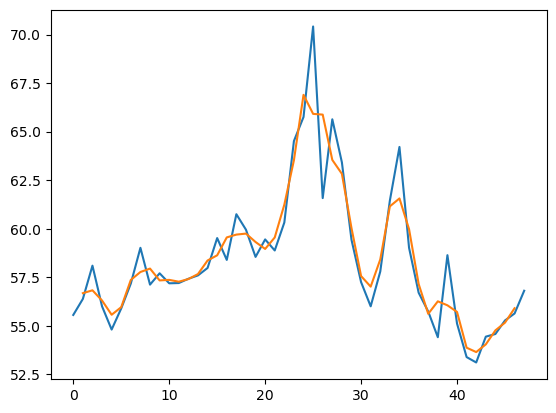

In [54]:
plt.plot(cwv_all[0,1,:,200,200])
plt.plot(cwv_3hr[0,1,:,200,200])

### Run binning

In [ ]:
def get_kstrat_cells(var_in, strat):
    
    var_indexed = []

    nstrat=6
    for kstrat in range(nstrat):
        indices = (strat == kstrat).nonzero()
        indexed_var = var_in[indices[0],indices[1],indices[2],indices[3]]
        var_indexed.append(indexed_var)

    return var_indexed

In [9]:
# var_np = get_kstrat_cells(var_all, strat_all)
# , var_dc, var_cg, var_sh, var_st, var_an = get_kstrat_cells(var_all, strat_all)

ktest=0
cwv_indexed_test0 = get_kstrat_cells(cwv_all[ktest], strat_all[ktest])

# ktest=1
# cwv_indexed_test1 = get_kstrat_cells(cwv_all[ktest], strat_all[ktest])

---
### Plotting routines

In [23]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 11}

matplotlib.rc('font', **font)

In [37]:
# Global boxplot settings

def create_boxplot(invar, title_tag, units, yscale='linear'):

    # c_name = ['Non-precip', 'Deep\nConvective', 'Congestus', 'Shallow\nConvective', 'Stratiform', 'Anvil']
    # cmap = ['white', 'teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
    c_name = ['Deep\nConvective', 'Congestus', 'Shallow\nConvective', 'Stratiform', 'Anvil']
    cmap = ['teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
    sns.set_palette(cmap)

    fig = plt.figure(figsize=(5.5,4),dpi=300)
    # fig.set_facecolor('white')
    ax = fig.subplots(nrows=1, ncols=1)
    # sns.boxplot([invar[0], invar[1], invar[2], invar[3], invar[4], invar[5]],
    sns.boxplot([invar[1], invar[2], invar[3], invar[4], invar[5]],
                width=0.7, showmeans=True, #log_scale=log_scale,
                meanprops={"marker":"o", "markerfacecolor":"white", 
                "markeredgecolor":"black", "markersize":"6"})

    ax.set_yscale(yscale)
    ax.set_xticklabels(c_name)
    plt.ylabel(units)#, weight='bold')
    plt.title("Class Averaged "+title_tag)#, weight='bold')

/tmp/ipykernel_38008/1837584661.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(c_name)
/tmp/ipykernel_38008/1837584661.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(c_name)


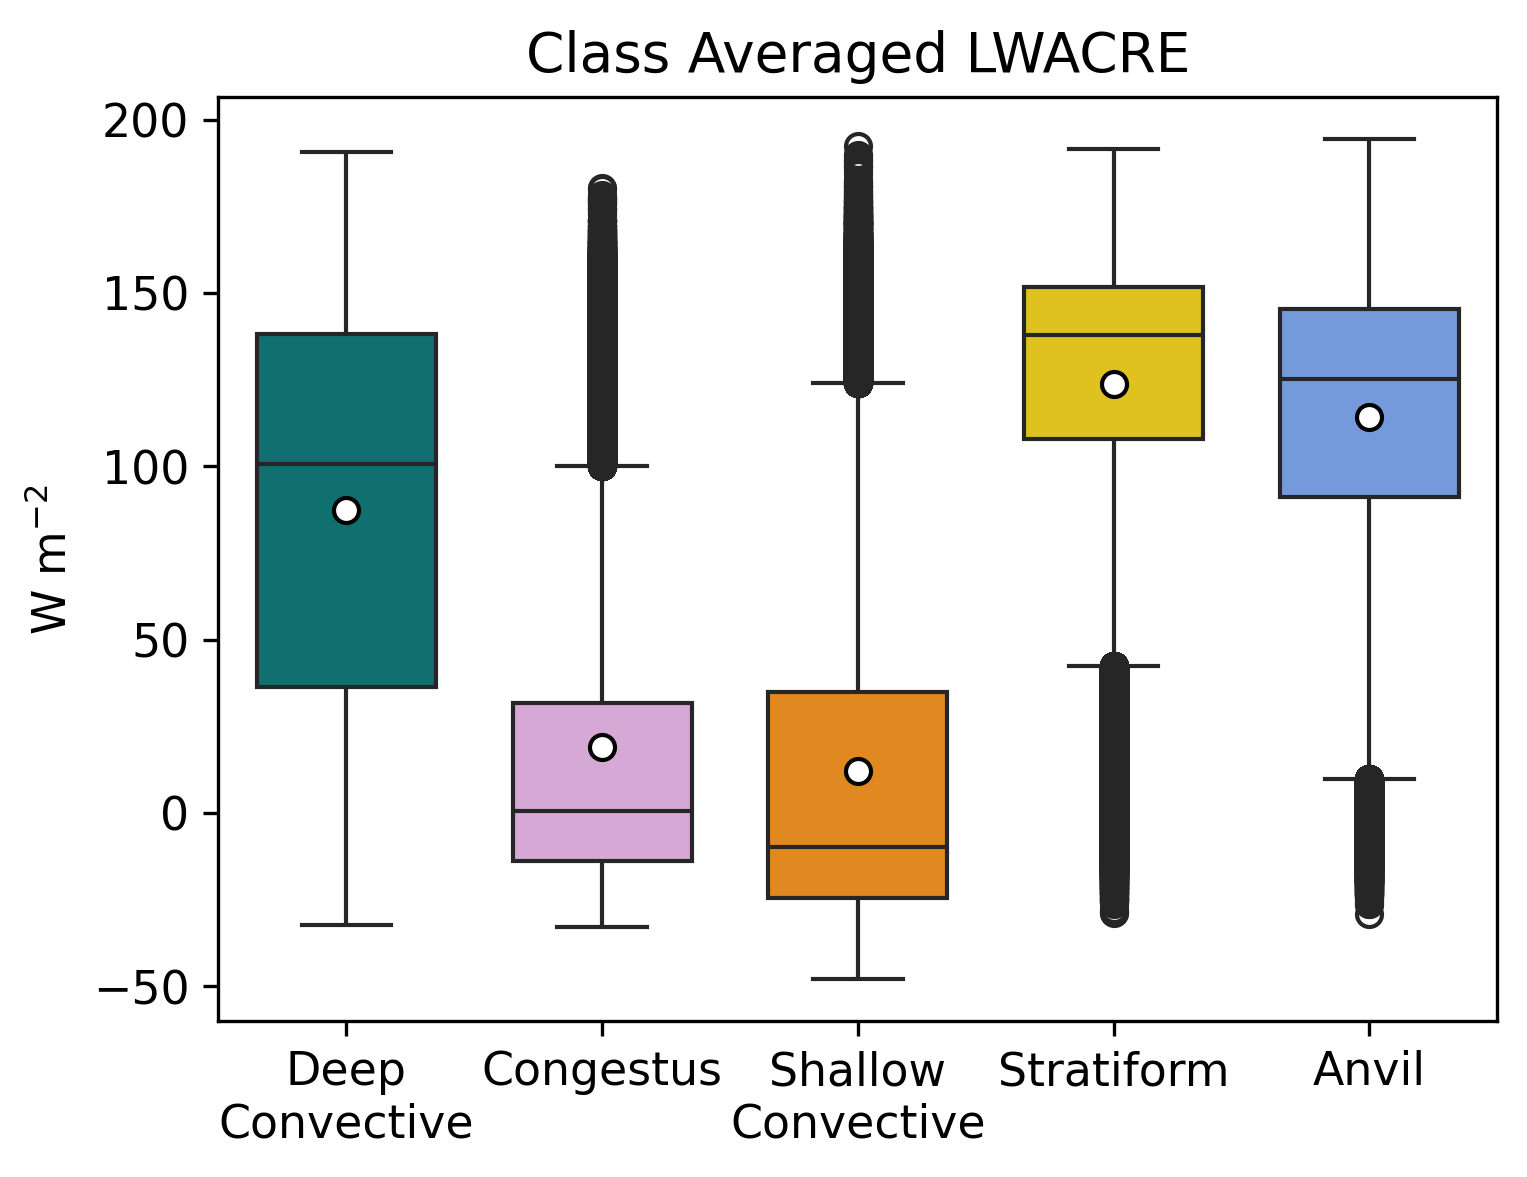

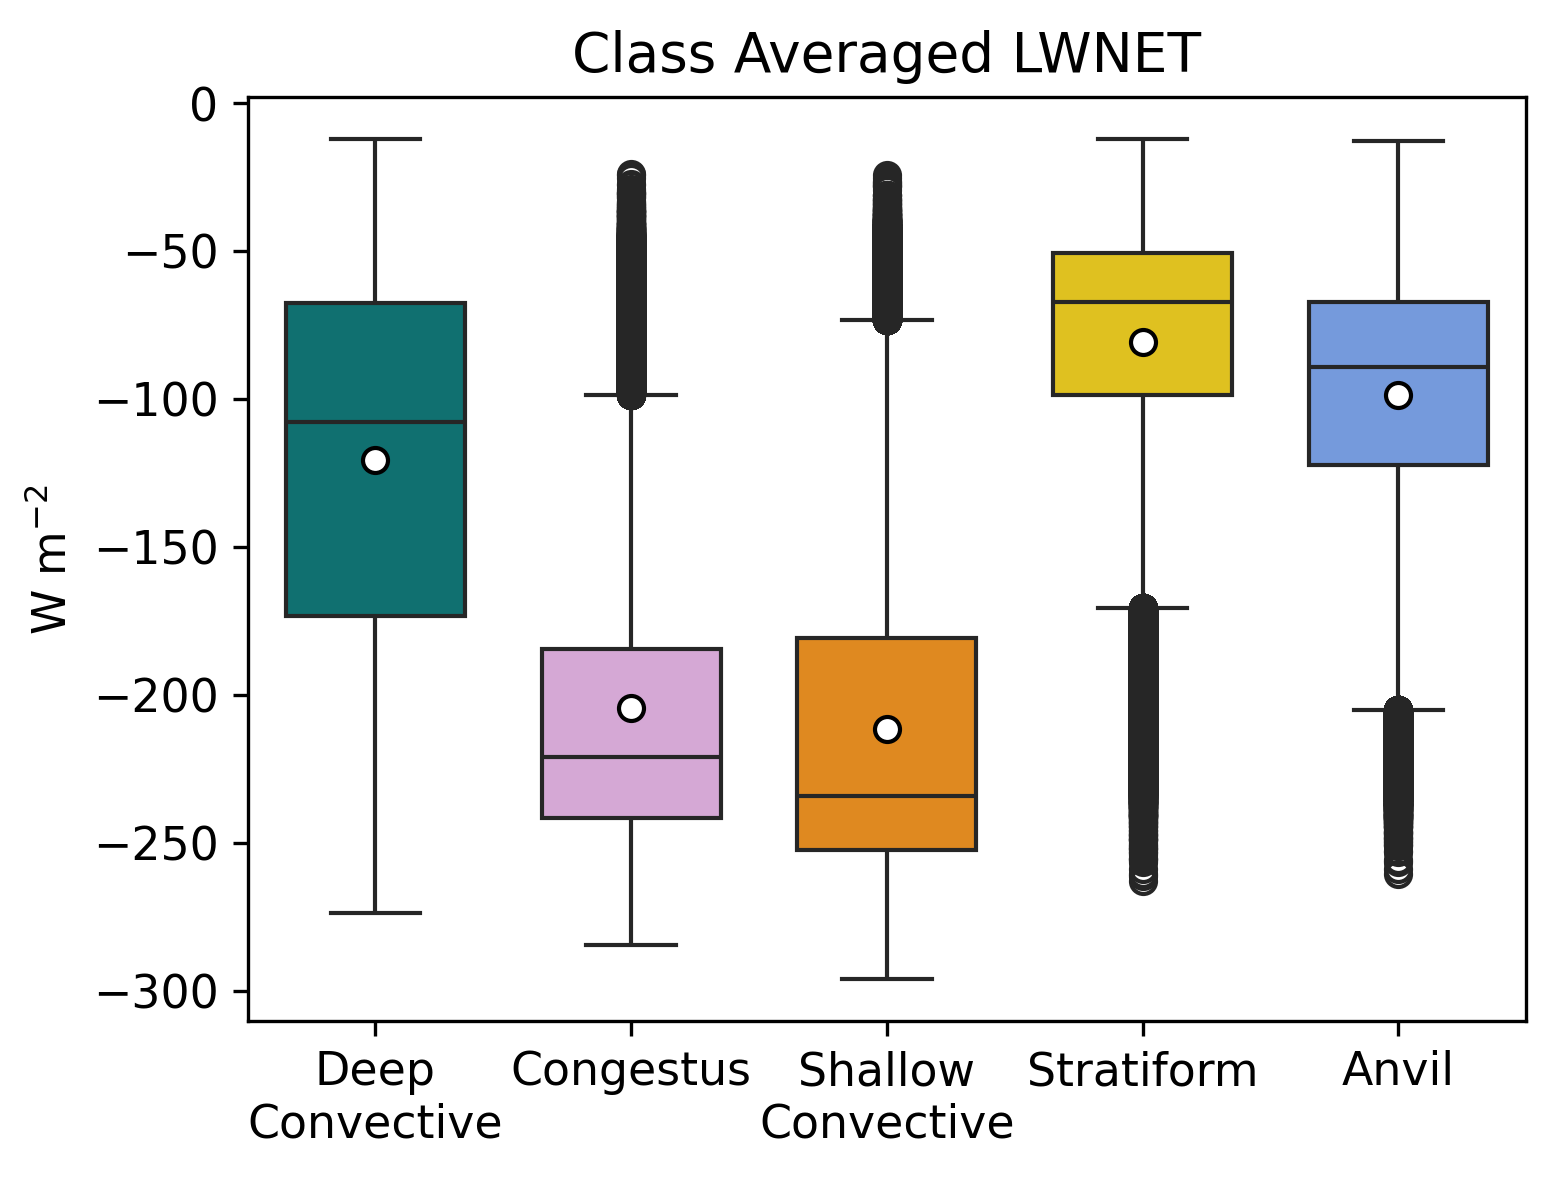

In [29]:
# LWACRE
title_tag = "LWACRE"
units = "W m$^{-2}$"
create_boxplot(lwacre_indexed_test0, title_tag, units)

# LWNET
title_tag = "LWNET"
create_boxplot(lwnet_indexed_test0, title_tag, units)

/tmp/ipykernel_38008/1837584661.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(c_name)


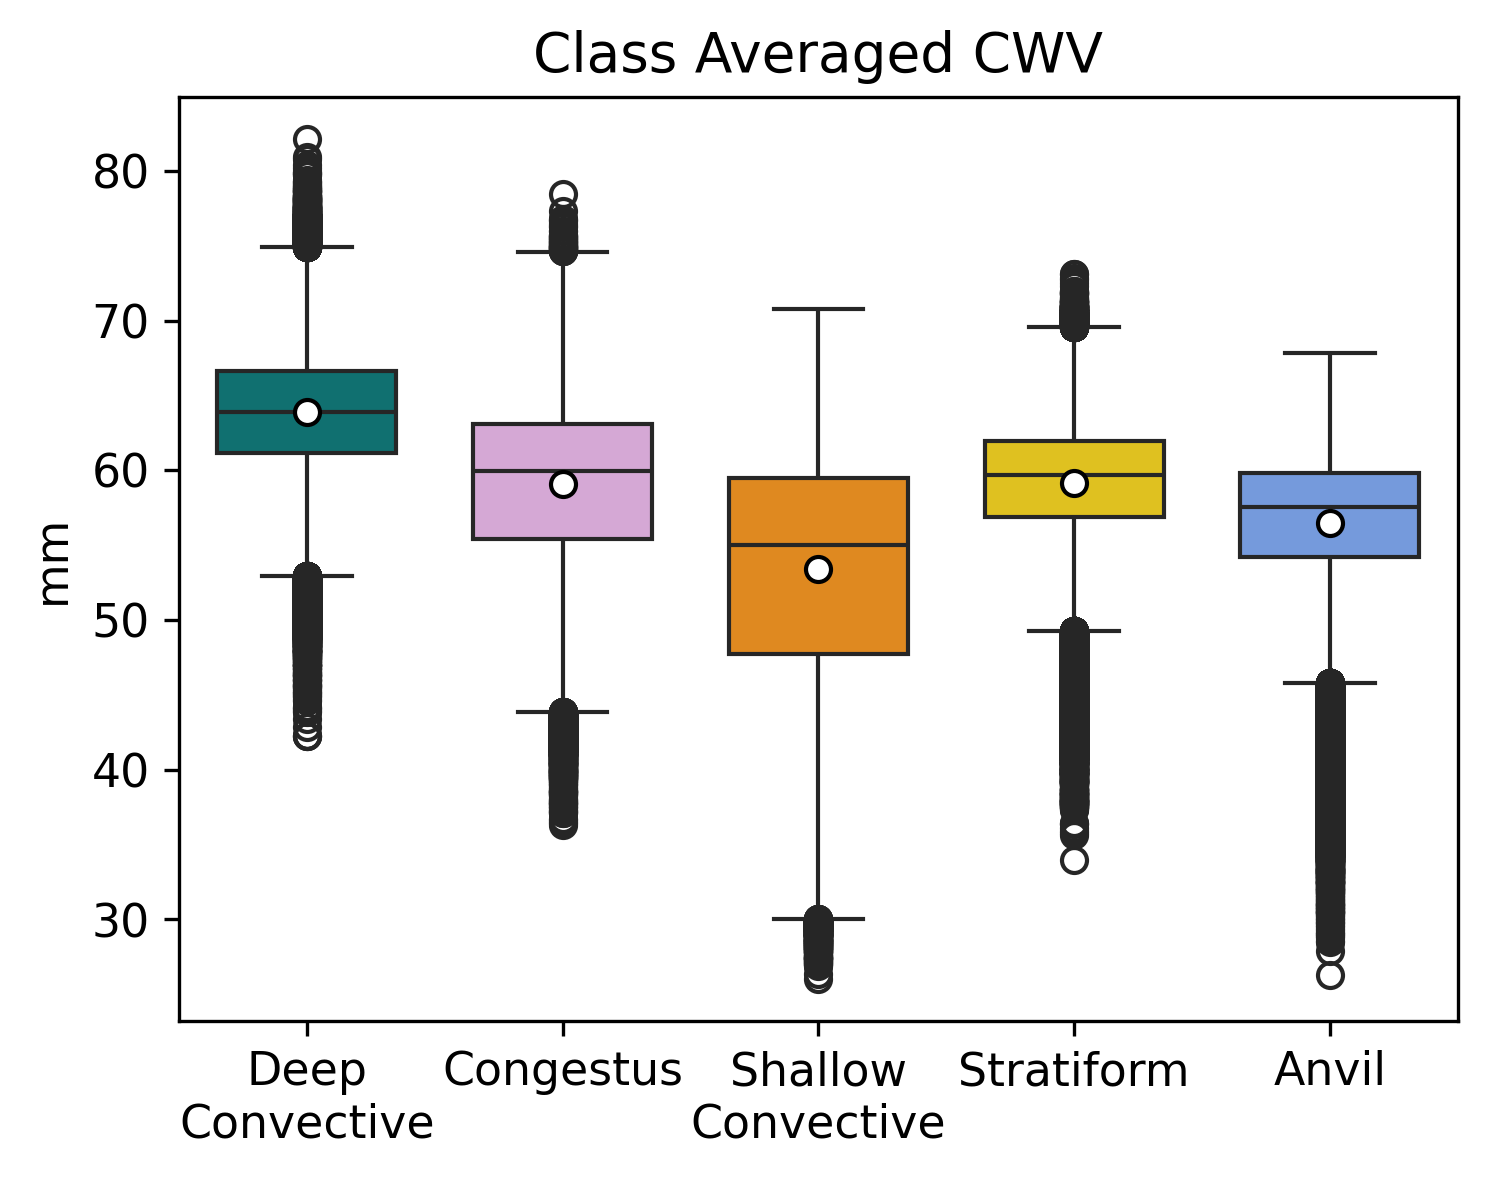

In [30]:
# CWV
title_tag = "CWV"
units = "mm"
create_boxplot(cwv_indexed_test0, title_tag, units)

/tmp/ipykernel_38008/1313510787.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(c_name)
/tmp/ipykernel_38008/1313510787.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(c_name)
/tmp/ipykernel_38008/1313510787.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(c_name)


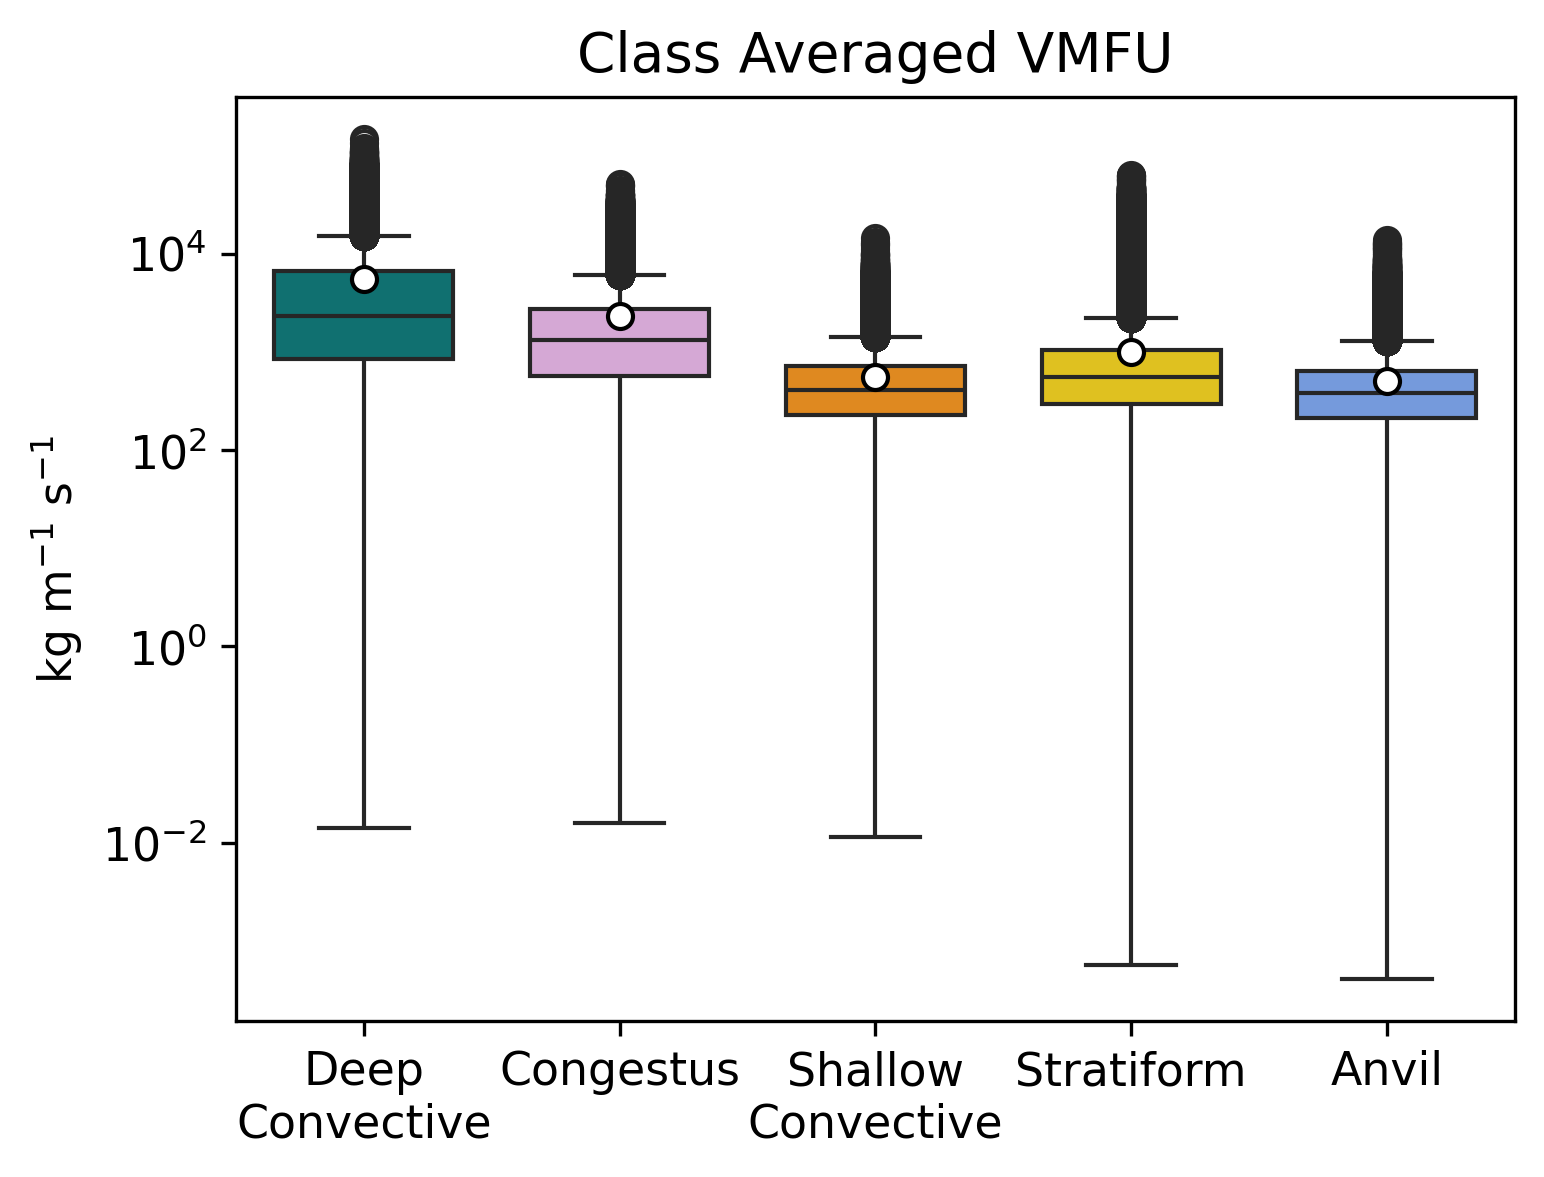

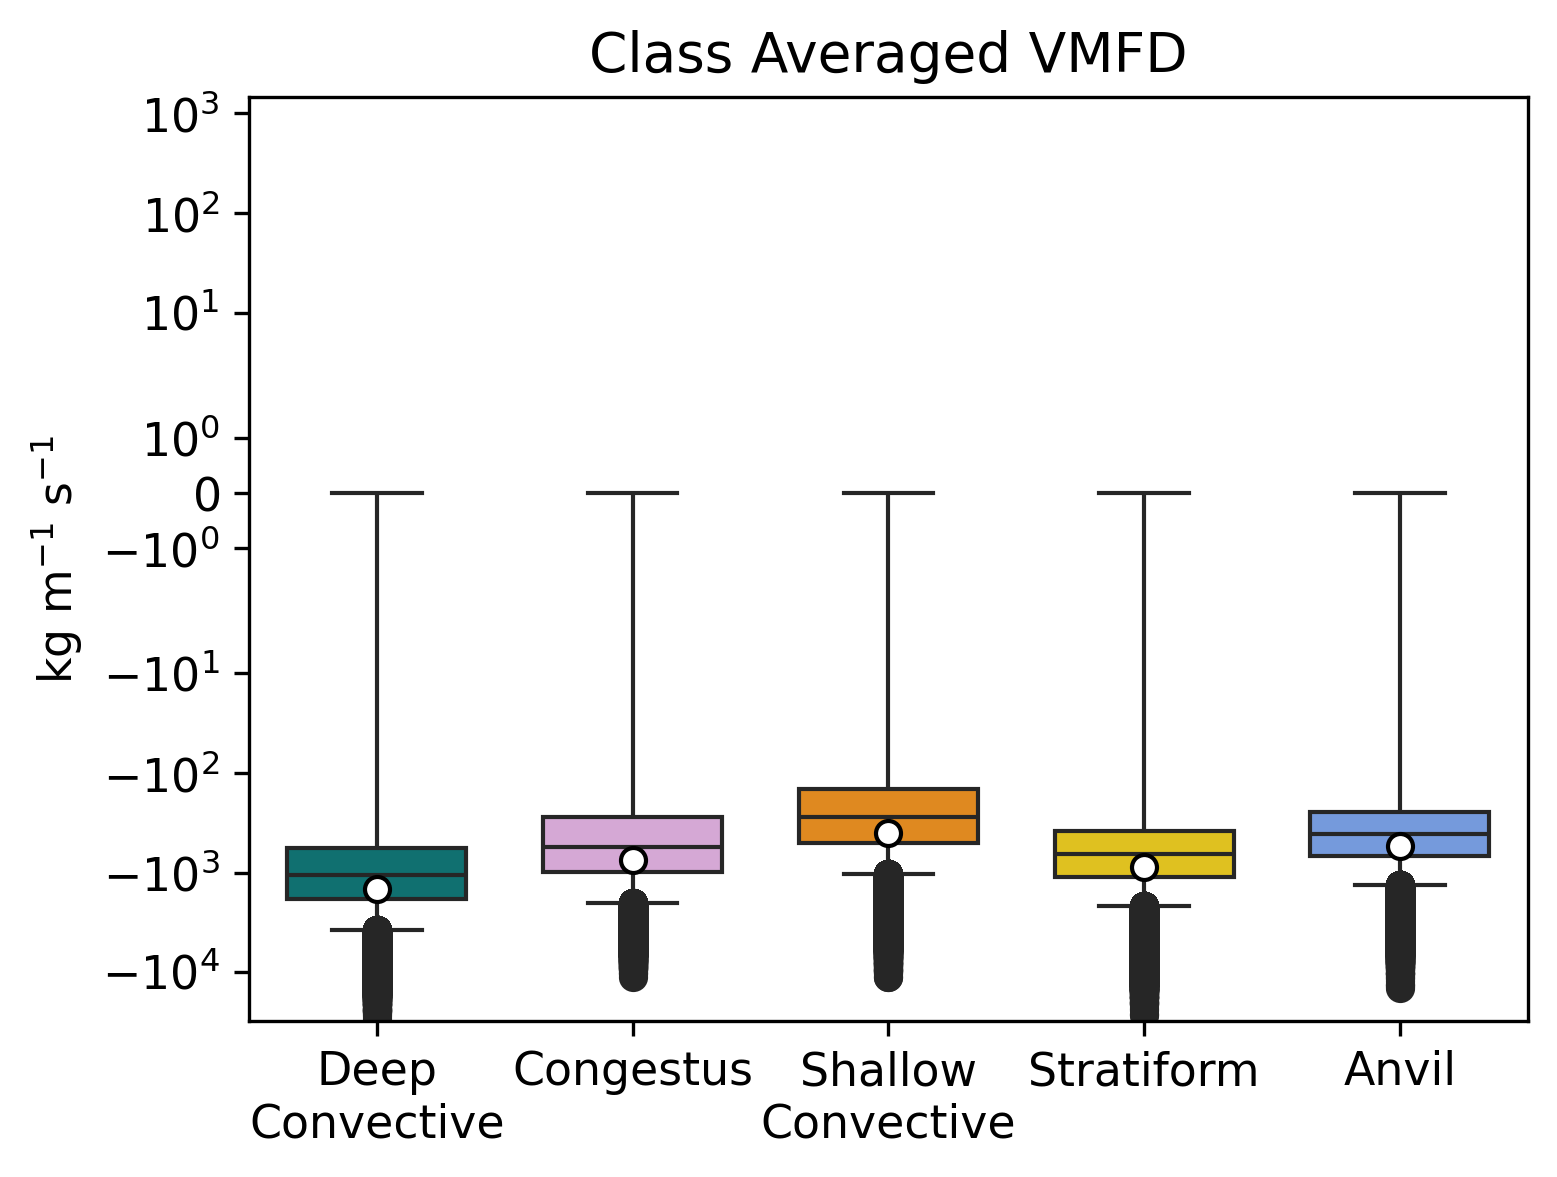

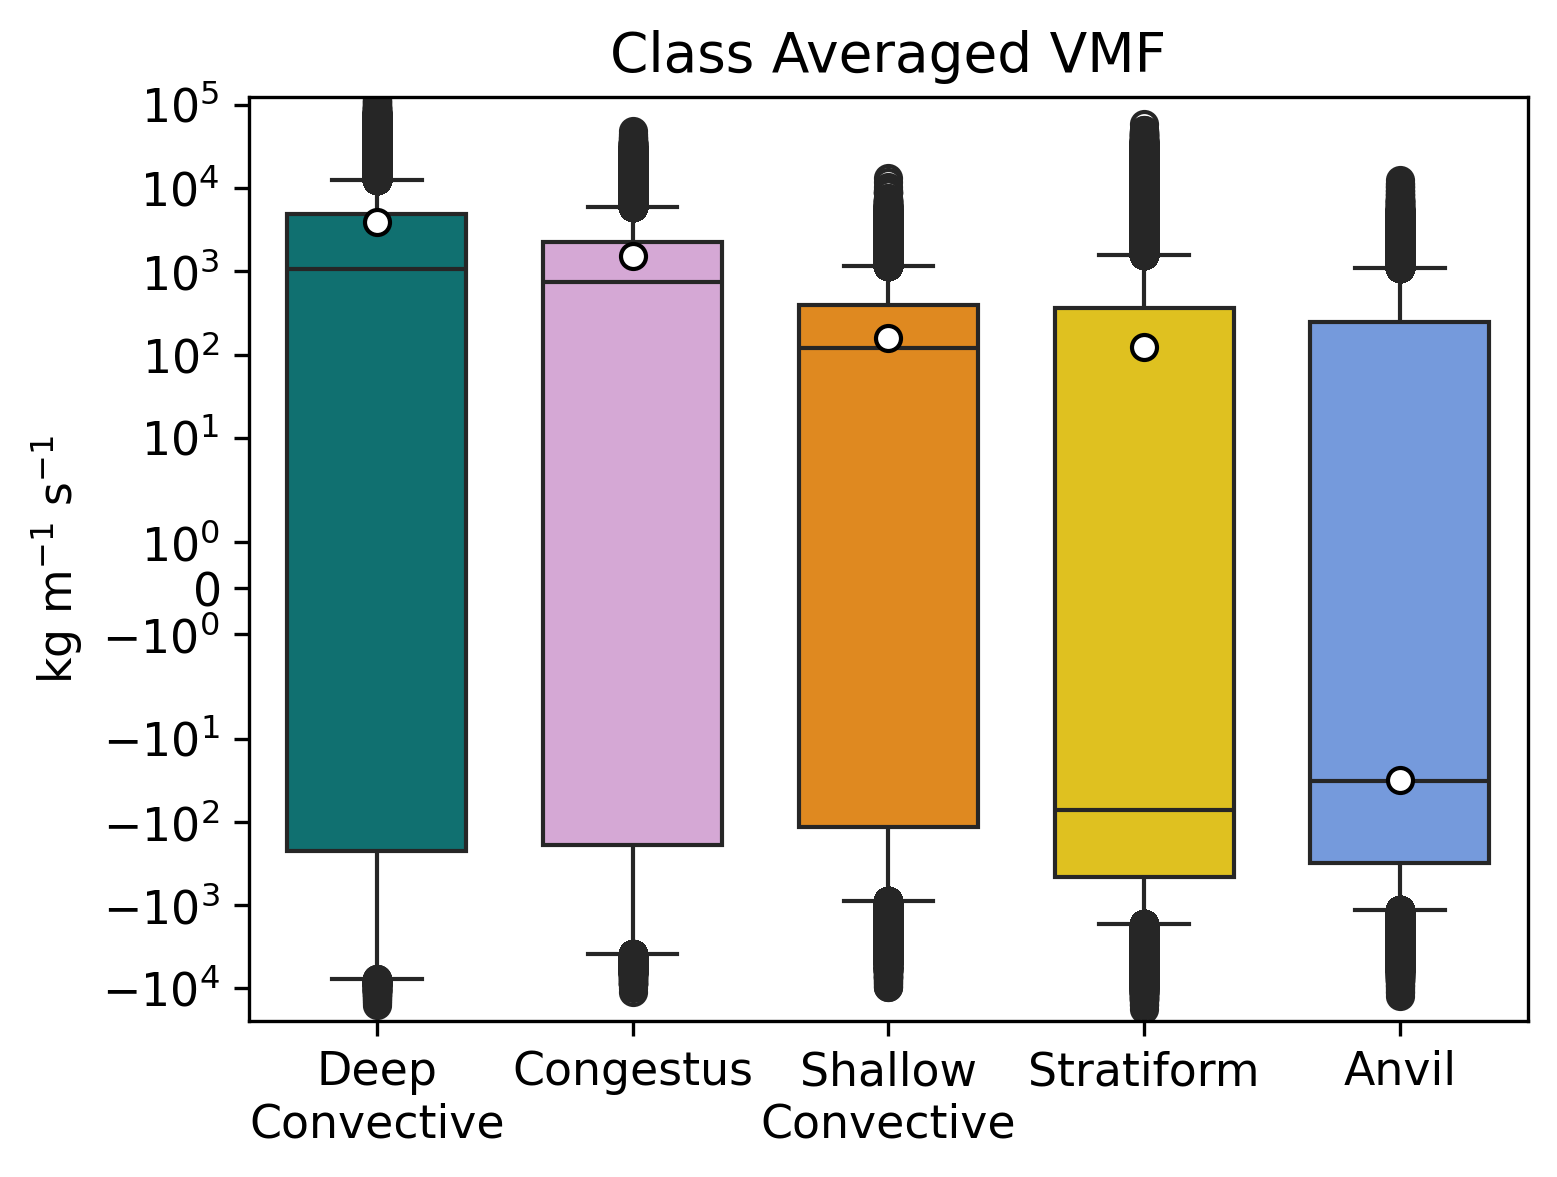

In [40]:
# VMFU
title_tag = "VMFU"
units = "kg m$^{-1}$ s$^{-1}$"
create_boxplot(vmfu_indexed_test0, title_tag, units, yscale='log')

# VMFD
title_tag = "VMFD"
create_boxplot(vmfd_indexed_test0, title_tag, units, yscale='symlog')

# VMF
title_tag = "VMF"
create_boxplot(vmf_indexed_test0, title_tag, units, yscale='symlog')